# Coursework 2: Neural Networks 

This coursework covers the topics covered in class regarding neural networks for image classification.

This coursework includes both coding questions as well as written ones. Please upload the notebook, which contains your code, results and answers as a pdf file onto Cate.

Dependencies: If you work on a college computer in the Computing Lab, where Ubuntu 18.04 is installed by default, you can use the following virtual environment for your work, where relevant Python packages are already installed.

`source /vol/bitbucket/wbai/virt/computer_vision_ubuntu18.04/bin/activate`

Alternatively, you can use pip, pip3 or anaconda etc to install Python packages.

**Note 1:** please read the both the text and code comment in this notebook to get an idea what you are supposed to implement.

**Note 2:** If you are using the virtual environment in the Computing Lab, please run the following command in the command line before opening jupyter-notebook and importing tensorflow. This will tell tensorflow where the Nvidia CUDA libariries are.

`export LD_LIBRARY_PATH=/vol/cuda/9.0.176/lib64/:"${LD_LIBRARY_PATH}}"` 

In [1]:
# Import libraries
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf 
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation 
import collections
import itertools
from PIL import Image

Using TensorFlow backend.


## Question 1 (20 points)

Throughout this coursework you will be working with the Fashion-MNIST dataset. If you are interested, you may find relevant information regarding the dataset in this paper.

[1] Fashion-MNIST: A novel image dataset for benchmarking machine learning algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf. [arXiv:1708.07747](https://arxiv.org/abs/1708.07747)

Be sure that you have the following files in your working directory: data.tar.gz and reader.py. Loading the data can be done as follows:

`from reader import get_images
(x_train, y_train), (x_test, y_test) = get_images()`

The dataset is already split into a set of 60,000 training images and a set of 10,000 test images. The images are of size 28x28 pixels and stored as 784-D vector. So if you would like to visualise the images, you need to reshape the array.

There are in total 10 label classes, which are:
* 0: T-shirt/top
* 1: Trousers
* 2: Pullover
* 3: Dress
* 4: Coat
* 5: Sandal
* 6: Shirt
* 7: Sneaker
* 8: Bag
* 9: Ankle boot

### 1.1 Load data (6 points)
Load the dataset and print the dimensions of the training set and the test set.

In [2]:
from reader import get_images
(x_train, y_train), (x_test, y_test) = get_images()
x_train = x_train / 255
x_test = x_test / 255
print ("Dimensions of the training set is %s with %s labels" % (str(x_train.shape), str(y_train.shape[0])))
print ("Dimensions of the test set is %s with %s labels" % (str(x_test.shape), str(y_test.shape[0])))

Dimensions of the training set is (60000, 784) with 60000 labels
Dimensions of the test set is (10000, 784) with 10000 labels


### 1.2 Visualize data (6 points)
Visualise 3 training images (T-shirt, trousers and pullover) and 3 test images (dress, coat and sandal).

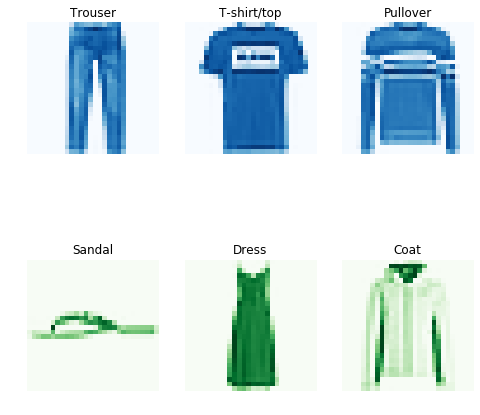

In [3]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

# https://www.kaggle.com/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist#

f, ax = plt.subplots(2, 3, figsize=(8, 8))
# 1, 5, 16 for train
# 6, 8, 13 for test
train_index = set([1, 5, 16])
test_index = set([6, 8, 13])
ite = set([0, 1, 2])
for i, j, k in zip(ite, train_index, test_index):
    ax[0, i].imshow(x_train[j].reshape(28, 28), cmap="Blues")
    ax[0, i].axis('off')
    ax[0, i].set_title(labels[y_train[j]])
    
    ax[1, i].imshow(x_test[k].reshape(28, 28), cmap="Greens")
    ax[1, i].axis('off')
    ax[1, i].set_title(labels[y_test[k]])
    
plt.show()

### 1.3 Data balance (4 points)
Print out the number of training samples for each class.

In [4]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = collections.Counter(data)

    # Get total number of samples
    total_samples = len(data)
    
    samp_values = list(label_counts.values())
    samp_keys = list(label_counts.keys())

    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[samp_keys[i]]
        count = samp_values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(y_train)

Ankle Boot          :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Bag                 :   6000 or 10.0%


### 1.4 Discussion (4 points)
Is the dataset balanced? What would happen if the dataset is not balanced in the context of image classification? 

The dataset is balanced, as each category is represented by 10%. If the dataset is not balanced, then the set will be biased towards a certain image classification. This would mean that it would favor the output of a certain label.

## Question 2 (40 points)

Build a neural network and train it with the Fashion-MNIST dataset. Here, we use the keras library, which is a high-level neural network library built upon tensorflow.

In [5]:
# Convert the label class into a one-hot representation
# 10 for the number of labels.
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### 2.1 Build a multi-layer perceptron, also known as multi-layer fully connected network. You need to define the layers, the loss function, the optimiser and evaluation metric. (30 points)

In [6]:
model = keras.models.Sequential()

model.add(Dense(1000, input_dim=784, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(10, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1000)              785000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10010     
Total params: 795,010
Trainable params: 795,010
Non-trainable params: 0
_________________________________________________________________
None


### 2.2 Define the optimisation parameters including the batch size and the number of epochs and then run the optimiser. (10 points)

We have tested that for an appropriate network architecture, on a personal laptop and with only CPU, it takes about a few seconds per epoch to train the network. For 100 epochs, it takes about a coffee break's time to finish the training. If you run it on a powerful GPU, it would be even much faster.

In [7]:
batch_size = 1024
epochs = 200
model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs)

Epoch 1/200
60000/60000 [==============================] - 3s 42us/step - loss: 0.7199 - acc: 0.7476
Epoch 2/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.4653 - acc: 0.8373
Epoch 3/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.4168 - acc: 0.8533
Epoch 4/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.3865 - acc: 0.8648
Epoch 5/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.3647 - acc: 0.8695
Epoch 6/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.3491 - acc: 0.8750
Epoch 7/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.3375 - acc: 0.8778
Epoch 8/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.3241 - acc: 0.8832
Epoch 9/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.3182 - acc: 0.8855
Epoch 10/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.3127 - a

60000/60000 [==============================] - 2s 37us/step - loss: 0.1376 - acc: 0.9487
Epoch 82/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.1372 - acc: 0.9478
Epoch 83/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1354 - acc: 0.9488
Epoch 84/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1356 - acc: 0.9495
Epoch 85/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1371 - acc: 0.9483
Epoch 86/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1350 - acc: 0.9493
Epoch 87/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.1333 - acc: 0.9499
Epoch 88/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1324 - acc: 0.9495
Epoch 89/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1283 - acc: 0.9520
Epoch 90/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.1321 - acc: 

60000/60000 [==============================] - 2s 35us/step - loss: 0.0891 - acc: 0.9665
Epoch 161/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.0892 - acc: 0.9663
Epoch 162/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.0844 - acc: 0.9680
Epoch 163/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.0871 - acc: 0.9666
Epoch 164/200
60000/60000 [==============================] - 2s 36us/step - loss: 0.0864 - acc: 0.9680
Epoch 165/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.0857 - acc: 0.9678
Epoch 166/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.0853 - acc: 0.9682
Epoch 167/200
60000/60000 [==============================] - 2s 35us/step - loss: 0.0845 - acc: 0.9688
Epoch 168/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.0831 - acc: 0.9682
Epoch 169/200
60000/60000 [==============================] - 2s 34us/step - loss: 0.080

## Question 3 (20 points) 

Evaluate the performance of your network with the test data. 
Visualize the performance using appropriate metrics and graphs (eg. confusion matrix). 
Comment on your per class performance and how it could be better.

In [8]:
# This function is provided for you to display the confusion matrix.
# For more information about the confusion matrix, you can read at
# https://en.wikipedia.org/wiki/Confusion_matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
        This function prints and plots the confusion matrix.
        
        cm: confusion matrix, default to be np.int32 data type
        classes: a list of the class labels or class names
        normalize: normalize the matrix so that each row amounts to one
        cmap: color map
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    cm = cm.astype(int)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### 3.1 Evaluate the classification accuracy on the test set (10 points)

In [9]:
loss, metric = model.evaluate(x = x_test, y = y_test)
print(loss)
print(metric)

10000/10000 [==============================] - 0s 36us/step
0.40662904716022313
0.9087


### 3.2 Calculate and plot the confusion matrix (10 points)

Confusion matrix, without normalization
[[856.   1.  13.  21.   3.   0. 100.   0.   6.   0.]
 [  6. 979.   2.   9.   2.   0.   1.   0.   1.   0.]
 [ 20.   1. 829.  11.  92.   2.  44.   0.   1.   0.]
 [ 11.   3.   9. 931.  24.   0.  17.   0.   5.   0.]
 [  0.   1.  64.  27. 868.   0.  39.   0.   1.   0.]
 [  0.   0.   0.   0.   0. 983.   0.  14.   0.   3.]
 [ 90.   1.  77.  22.  79.   0. 727.   0.   4.   0.]
 [  0.   0.   0.   0.   0.   7.   0. 970.   0.  23.]
 [  4.   0.   4.   5.   2.   1.   1.   4. 979.   0.]
 [  0.   0.   0.   0.   0.  10.   1.  24.   0. 965.]]


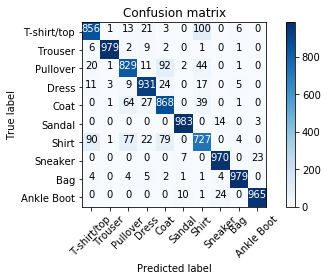

In [10]:
predictions = model.predict(x_test)
matrix = np.zeros((10, 10))

for i in range(len(predictions)):
    maxp = np.argmax(predictions[i])
    actual = np.argmax(y_test[i])
    matrix[actual][maxp] += 1
    
plot_confusion_matrix(matrix, list(labels.values()))

### 3.3 Comment on your per class performance and how it could be better.

T-Shirt/top : Correct 85.6% of the time. Most errors due to it being classified as a Shirt.

Trousers: Correct 97.9% of the time. No major errors.

Pullovers: Correct 82.9% of the time. Most errors due to it being classified as a Coat and sometimes as a Shirt.

Dress: Correct 93.1% of the time. No major errors. 

Coat: Correct 86.8% of the time. Most errors due to it being classified as a Pullover.

Sandal: Correct 98.3% of the time. No major errors.

Shirt: Correct 72.7% of the time. Majority of the errors are due to the Shirt being classified as other upper-body clothes, mainly Shirt, Pullover and Coat.

Sneaker: Correct 97.0% of the time. No major errors.

Bag: Correct 97.9% of the time. No major errors.

Anke Boot: Correct 96.5% of the time. Small error due to it sometimes being classified as a Sneaker.

Overall, the classification is pretty good. The biggest error comes with the Shirt class, that gets heavily confused with other upper-body clothes. 

To make this better, we want the Shirt to be more correct. One way of doing this is by providing the training set with more Shirt images. The issue with this approach would be that the model then becomes biased towards the Shirt and other upper-body clothes now get predicted as Shirts. Another alternative would be to increase the sample size for each image. This would allow for the model to adjust its weights more to help with Shirt prediction. 

## Question 4 (20 points)
Take two photos, one of your clothes or shoes that belongs to one of 10 classes, the other that does not belong to any class.

Use either Python or other software (Photoshop, Gimp, or any image editer) to convert the photos into grayscale, crop the region of interest and reshape into the size of 28x28.

### 4.1 Load and visualise your own images (6 points)

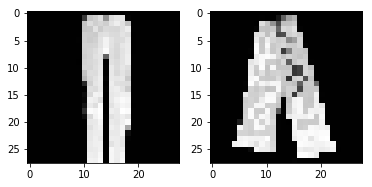

In [11]:
scarf = tf.image.decode_jpeg(tf.read_file('scarf1.jpg'))
trousers = tf.image.decode_jpeg(tf.read_file('trousers1.jpeg'))
resized_scarf = tf.image.resize_images(scarf, [28, 28])
resized_trousers = tf.image.resize_images(trousers, [28, 28])
gray_scarf = tf.image.rgb_to_grayscale(resized_scarf)
gray_trousers = tf.image.rgb_to_grayscale(resized_trousers)

stf = 1 - tf.Variable(gray_scarf) / 255
ttf = 1 - tf.Variable(gray_trousers) / 255
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)
ims = sess.run(stf)
ims.resize((28, 28))
imt = sess.run(ttf)
imt.resize((28, 28))
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(imt, cmap="gray")
fig.add_subplot(1,2,2)
plt.imshow(ims, cmap="gray")
plt.show()

### 4.2 Test your network on the two images and show the classification results (10 points)

In [12]:
def printPrediction(predictions):
    
    res = np.argmax(predictions)
    conf = predictions[0][res] * 100
    resClass = list(labels.values())[res]
    
    print("Percentages:")
    print(["{0:.3f}".format(pred * 100) for pred in predictions[0]])
    print("Model is {0:.3f}% sure image is ".format(conf) + resClass)
    
    
    

In [13]:
prediction = model.predict(np.reshape(imt, [1, 784]))
printPrediction(prediction)

Percentages:
['0.000', '100.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000', '0.000']
Model is 100.000% sure image is Trouser


In [14]:
prediction = model.predict(np.reshape(ims, [1, 784]))
printPrediction(prediction)

Percentages:
['0.000', '95.866', '0.000', '0.004', '0.064', '0.000', '0.016', '0.000', '4.049', '0.000']
Model is 95.866% sure image is Trouser


### 4.3 Discuss the classification results and provide one method to improve real life performance of the network (4 points)

The model correctly predicts the classification for the trousers picture, as it was one of the categories from the training set. 

The model classified the scarf as trousers as well, with a 96% accuracy. This can be easily understood by the fact that the scarf picture looks very similar to trousers. 

To improve real life performance, we could first of all use a larger training set. We could also modify the training data to contain:

1) Rotated images

2) Cropped images 

3) Flipped images

Another possibility would be to use higher resolution images for training, so there is more room for features specific to certain labels (could help with the confusion between Shirt and other upper-body clothes). 

## 5. Survey
How long did the coursework take you to solve? 

7 Hours